In [162]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd
import re
import time

pd.options.display.max_rows = 300

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp",
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude",
]
TYPES_911 = [str, str, float, str, str, str, int, float, float]

In [92]:
# violent
close_proxy = ['ASSAULT','SHOTS','SHOOTING','CUTTING','HOLD UP','WEAP','ROBBERY ARMED','VIOLENT - ARMED','RAPE','STABBED','SHOT']
near_proxy = ['WITH WEAPON','DV','ABUSE','BREAKING AND ENTERING','BREAKING & ENTERING']
expr = re.compile('|'.join(close_proxy))

In [93]:
# use a generator function to select rows we want in chunks rather than loading everything into memory at once
generator = pd.read_csv(
    "calls_for_service_from_jimmy.csv",
    nrows=None,
    usecols=COLS_911,
    parse_dates=["call_timestamp"],
    chunksize=1e4,
    dtype=dict(zip(COLS_911, TYPES_911)),
)

call = (
    pd.concat(
        [x.loc[lambda x: x.calldescription.str.contains(expr)] for x in generator],
        ignore_index=True,
    )
)

call = gpd.GeoDataFrame(call,geometry=gpd.points_from_xy(call.longitude,call.latitude),crs='epsg:4327')

In [94]:
call.shape

(371176, 9)

In [176]:
block_count = (
    call.groupby("block_id")
    .oid.count()
    .rename("call_count")
    .sort_values(ascending=False)
)
block_count.head()
# representation_ratio = block_count/block_count.mean()

block_id
2.616354e+14    1819
2.616353e+14    1540
2.616350e+14    1281
2.616352e+14     924
2.616352e+14     851
Name: call_count, dtype: int64

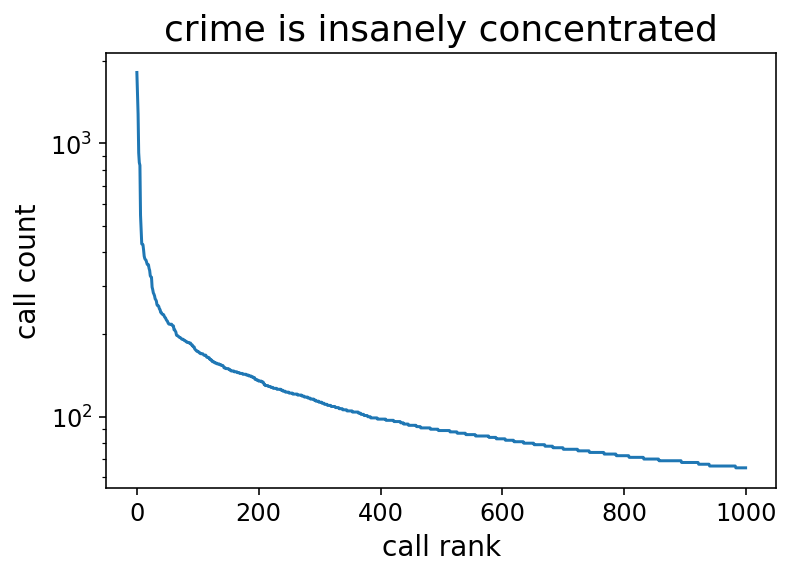

In [164]:
plt.plot(range(1000),block_count.head(1000))
_ = plt.gca().set(yscale='log',title='crime is concentrated',ylabel='call count',xlabel='call rank')

In [171]:
pop = pd.read_csv(
    "/Users/ahakso/Downloads/productDownload_2022-01-28T162855/DECENNIALSF12010.P10_data_with_overlays_2022-01-28T162836.csv",
    usecols=["GEO_ID", "P010001"],
    skiprows=[1],
).rename(columns={"GEO_ID": "block_id", "P010001": "population"})
pop = pop.assign(
    block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1])
).astype({"block_id": float})

In [181]:
block_count.shape

(14581,)

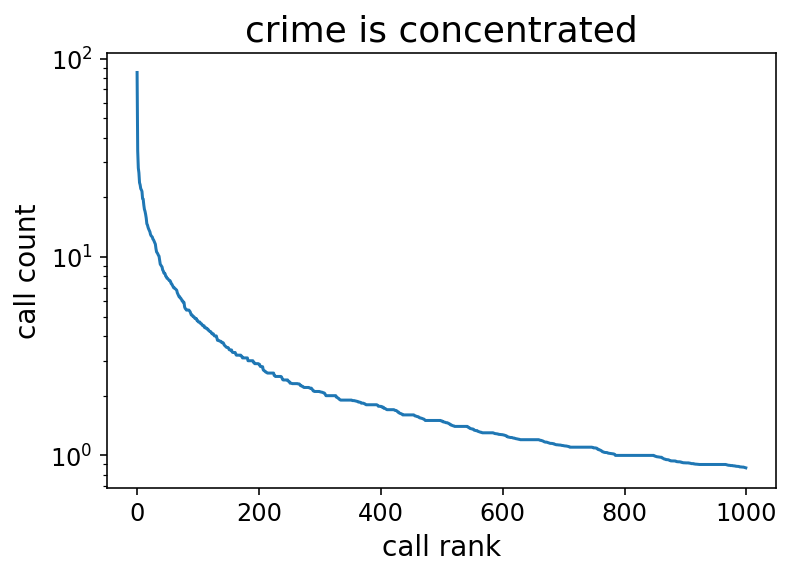

In [182]:
# losing 2/3 of call rows in this join for some reason
df = pd.merge(block_count, pop, left_index=True, right_on="block_id").assign(
    calls_per_capita=lambda x: x.call_count / (x.population + 10)
).sort_values("calls_per_capita", ascending=False)
plt.plot(range(1000),df.head(1000).calls_per_capita)
_ = plt.gca().set(yscale='log',title='crime is concentrated',ylabel='calls per capita',xlabel='call rank')